<a href="https://colab.research.google.com/github/ImNotDanish05/2025_PBO_TI-1A/blob/main/Jobsheet_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00


# **Package**

In [2]:
from pyngrok import ngrok
import time
import subprocess
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Danish05/Account/ngrok.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if "Token:" in line:
            token = line.split("Token:")[1].strip()

Mounted at /content/drive


# **Web Hoster**

In [3]:
# Run streamlit
def web(apps):
  !ngrok config add-authtoken {token}
  time.sleep(5)
  process = subprocess.Popen(['streamlit', 'run', f'/content/{apps}', '--server.headless', 'true', '--server.port', '8501', '--server.enableCORS', 'false'])

  # Ngrok tunnel
  public_url = ngrok.connect("http://localhost:8501")
  print("Streamlit ready at:", public_url)
  killngrok()

def killngrok():
  while True:
    jawab = input('Apakah anda selesai ? Tulis "iya" jika selesai: ').strip().lower()
    if jawab == "iya":
      print("Oke, hancurkan ngrok")
      ngrok.kill()
      break
    else:
      print(f"=== Salah Input ===")

In [4]:
ngrok.kill()

# **Testing Website Host**

In [5]:
# Buat file app.py, dan isi di dalamnya
%%writefile testapp.py
# Isi di dalamnya
import streamlit as st
st.title("Hello Colab!")

Writing testapp.py


In [6]:
# Hosting Web
# web("testapp.py")

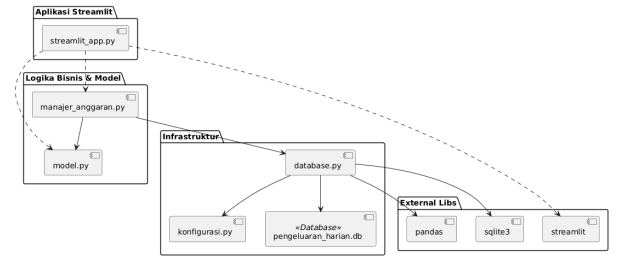

# **Langkah 1: Persiapan Awal**

In [7]:
# File 1: Konfigurasi.py
%%writefile konfigurasi.py
import os

# Path dasar direktori file ini
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# Nama dan path database
NAMA_DB = 'pengeluaran_harian.db'
DB_PATH = os.path.join(BASE_DIR, NAMA_DB)

# Daftar kategori pengeluaran
KATEGORI_PENGELUARAN = [
    "Makanan", "Transportasi", "Hiburan", "Tagihan",
    "Belanja", "Kesehatan", "Pendidikan", "Lainnya"
]

# Kategori default jika tidak ditentukan
KATEGORI_DEFAULT = "Lainnya"


Writing konfigurasi.py


In [8]:
# File 2: setup_db_pengeluaran.py
%%writefile setup_db_pengeluaran.py
import sqlite3
import os
from konfigurasi import DB_PATH

def setup_database():
    print(f"Memeriksa/membuat database di: {DB_PATH}")
    conn = None

    try:
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()

        # SQL untuk membuat tabel jika belum ada
        sql_create_table = """
        CREATE TABLE IF NOT EXISTS transaksi (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            deskripsi TEXT NOT NULL,
            jumlah REAL NOT NULL CHECK(jumlah > 0),
            kategori TEXT,
            tanggal DATE NOT NULL
        );
        """

        print("Membuat tabel 'transaksi' (jika belum ada)...")
        cursor.execute(sql_create_table)
        conn.commit()
        print("-> Tabel 'transaksi' siap.")
        return True

    except sqlite3.Error as e:
        print(f"-> Error SQLite saat setup: {e}")
        return False

    finally:
        if conn:
            conn.close()
            print("-> Koneksi DB setup ditutup.")

if __name__ == "__main__":
    print("--- Memulai Setup Database Pengeluaran ---")
    if setup_database():
        print(f"\nSetup database '{os.path.basename(DB_PATH)}' selesai.")
    else:
        print("\nSetup database GAGAL.")
    print("--- Setup Database Selesai ---")

Writing setup_db_pengeluaran.py


# **Langkah 2: Modul Akses Database (database.py)**

In [9]:
# File 3: database.py
%%writefile database.py
import sqlite3
import pandas as pd
from konfigurasi import DB_PATH  # Gunakan path dari konfigurasi


def get_db_connection() -> sqlite3.Connection | None:
    """Membuka dan mengembalikan koneksi baru ke database SQLite."""
    try:
        conn = sqlite3.connect(
            DB_PATH,
            timeout=10,
            detect_types=sqlite3.PARSE_DECLTYPES
        )
        conn.row_factory = sqlite3.Row  # Akses kolom by name
        return conn
    except sqlite3.Error as e:
        print(f"ERROR [database.py] Koneksi DB gagal: {e}")
        return None

def execute_query(query: str, params: tuple = None):
    """
    Menjalankan query non-SELECT (seperti INSERT, UPDATE, DELETE).
    Mengembalikan lastrowid jika berhasil (untuk INSERT).
    """
    conn = get_db_connection()
    if not conn:
        return None

    try:
        cursor = conn.cursor()
        if params:
            cursor.execute(query, params)
        else:
            cursor.execute(query)
        conn.commit()
        return cursor.lastrowid
    except sqlite3.Error as e:
        print(f"ERROR [database.py] Query gagal: {e} | Query: {query[:60]}")
        conn.rollback()
        return None
    finally:
        if conn:
            conn.close()


def fetch_query(query: str, params: tuple = None, fetch_all: bool = True):
    """
    Menjalankan query SELECT dan mengembalikan hasil:
    - fetch_all=True: list of rows
    - fetch_all=False: single row
    """
    conn = get_db_connection()
    if not conn:
        return None

    try:
        cursor = conn.cursor()
        if params:
            cursor.execute(query, params)
        else:
            cursor.execute(query)
        result = cursor.fetchall() if fetch_all else cursor.fetchone()
        return result
    except sqlite3.Error as e:
        print(f"ERROR [database.py] Fetch gagal: {e} | Query: {query[:60]}")
        return None
    finally:
        if conn:
            conn.close()

def get_dataframe(query: str, params: tuple = None) -> pd.DataFrame:
    """Menjalankan query SELECT dan mengembalikan hasil sebagai DataFrame Pandas."""
    conn = get_db_connection()
    if not conn:
        return pd.DataFrame()

    try:
        df = pd.read_sql_query(query, conn, params=params)
        return df
    except Exception as e:
        print(f"ERROR [database.py] Gagal baca ke DataFrame: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()

def setup_database_initial():
    """
    Memastikan tabel 'transaksi' ada.
    Dapat dipanggil saat aplikasi pertama kali dijalankan.
    """
    print(f"Memeriksa/membuat tabel di database (via database.py): {DB_PATH}")
    conn = get_db_connection()
    if not conn:
        return False

    try:
        cursor = conn.cursor()
        sql_create_table = """
        CREATE TABLE IF NOT EXISTS transaksi (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            deskripsi TEXT NOT NULL,
            jumlah REAL NOT NULL CHECK(jumlah > 0),
            kategori TEXT,
            tanggal DATE NOT NULL
        );
        """
        cursor.execute(sql_create_table)
        conn.commit()
        print("-> Tabel 'transaksi' siap.")
        return True
    except sqlite3.Error as e:
        print(f"Error SQLite saat setup tabel: {e}")
        return False
    finally:
        if conn:
            conn.close()

Writing database.py


# **Langkah 3: Modul Model Data (model.py)**

In [10]:
# File 4: model.py
%%writefile model.py
import datetime

class Transaksi:
    """Merepresentasikan satu entitas transaksi pengeluaran."""

    def __init__(self, deskripsi: str, jumlah: float, kategori: str,
                 tanggal: datetime.date | str, id_transaksi: int | None = None):
        self.id = id_transaksi
        self.deskripsi = str(deskripsi).strip() if deskripsi else "Tanpa Deskripsi"

        try:
            jumlah_float = float(jumlah)
            self.jumlah = jumlah_float if jumlah_float > 0 else 0.0
            if jumlah_float <= 0:
                print(f"Peringatan: Jumlah '{jumlah}' harus positif.")
        except (ValueError, TypeError):
            self.jumlah = 0.0
            print(f"Peringatan: Jumlah '{jumlah}' tidak valid.")

        self.kategori = str(kategori).strip() if kategori else "Lainnya"

        if isinstance(tanggal, datetime.date):
            self.tanggal = tanggal
        elif isinstance(tanggal, str):
            try:
                self.tanggal = datetime.datetime.strptime(tanggal, "%Y-%m-%d").date()
            except ValueError:
                self.tanggal = datetime.date.today()
                print(f"Peringatan: Format tanggal '{tanggal}' salah.")
        else:
            self.tanggal = datetime.date.today()
            print(f"Peringatan: Tipe tanggal '{type(tanggal)}' tidak valid.")

    def __repr__(self) -> str:
        try:
            import locale
            locale.setlocale(locale.LC_ALL, 'id_ID.UTF8')
            jml_str = locale.format_string("%.0f", self.jumlah, grouping=True)
        except:
            jml_str = f"{self.jumlah:.0f}"

        return (
            f"Transaksi(ID:{self.id}, "
            f"Tgl:{self.tanggal.strftime('%Y-%m-%d')}, "
            f"Jml:{jml_str}, "
            f"Kat:'{self.kategori}', "
            f"Desc:'{self.deskripsi}')"
        )

    def to_dict(self) -> dict:
        return {
            "deskripsi": self.deskripsi,
            "jumlah": self.jumlah,
            "kategori": self.kategori,
            "tanggal": self.tanggal.strftime("%Y-%m-%d")
        }


Writing model.py


# **Langkah 4: Modul Manajer Anggaran (manajer_anggaran.py)**

In [11]:
# File 5: manajer_anggaran.py
%%writefile manajer_anggaran.py

import datetime
import pandas as pd
from model import Transaksi
import database  # Impor modul database kita

class AnggaranHarian:
    """Mengelola logika bisnis pengeluaran harian (Repository Pattern)."""

    _db_setup_done = False  # Setup DB hanya dilakukan sekali per sesi

    def __init__(self):
        if not AnggaranHarian._db_setup_done:
            print("[AnggaranHarian] Melakukan pengecekan/setup database awal...")
            if database.setup_database_initial():
                AnggaranHarian._db_setup_done = True
                print("[AnggaranHarian] Database siap.")
            else:
                print("[AnggaranHarian] KRITIKAL: Setup database awal GAGAL!")

    def tambah_transaksi(self, transaksi: Transaksi) -> bool:
        if not isinstance(transaksi, Transaksi) or transaksi.jumlah <= 0:
            return False

        sql = """
            INSERT INTO transaksi (deskripsi, jumlah, kategori, tanggal)
            VALUES (?, ?, ?, ?)
        """
        params = (
            transaksi.deskripsi,
            transaksi.jumlah,
            transaksi.kategori,
            transaksi.tanggal.strftime("%Y-%m-%d")
        )
        last_id = database.execute_query(sql, params)

        if last_id is not None:
            transaksi.id = last_id
            return True
        return False

    def hapus_transaksi(self, id_transaksi: int) -> bool:
        """ Menghapus transaksi berdasarkan ID """
        sql = "DELETE FROM transaksi WHERE id = ?"
        try:
          result = database.execute_query(sql, (id_transaksi,))
          return result is not None and result > 0
        except Exception as e:
          print(f"[AnggaranHarian] Error saat menghapus transaksi {id_transaksi,}: {e}")
          return False

    def get_semua_transaksi_obj(self) -> list[Transaksi]:
        sql = """
            SELECT id, deskripsi, jumlah, kategori, tanggal
            FROM transaksi
            ORDER BY tanggal DESC, id DESC
        """
        rows = database.fetch_query(sql, fetch_all=True)
        transaksi_list = []

        if rows:
            for row in rows:
                transaksi_list.append(
                    Transaksi(
                        id_transaksi=row['id'],
                        deskripsi=row['deskripsi'],
                        jumlah=row['jumlah'],
                        kategori=row['kategori'],
                        tanggal=row['tanggal']
                    )
                )
        return transaksi_list

    def get_dataframe_transaksi(self, filter_tanggal: datetime.date | None = None) -> pd.DataFrame:
        query = """
            SELECT id, tanggal, kategori, deskripsi, jumlah
            FROM transaksi
        """
        params = None

        if filter_tanggal:
            query += " WHERE tanggal = ?"
            params = (filter_tanggal.strftime("%Y-%m-%d"),)

        query += " ORDER BY tanggal DESC, id DESC"
        df = database.get_dataframe(query, params=params)

        if not df.empty:
            try:
                import locale
                locale.setlocale(locale.LC_ALL, 'id_ID.UTF-8')
                df['Jumlah (Rp)'] = df['jumlah'].map(
                    lambda x: locale.currency(x or 0, grouping=True, symbol='Rp ')[:-3]
                )
            except:
                df['Jumlah (Rp)'] = df['jumlah'].map(
                    lambda x: f"Rp {x or 0:,.0f}".replace(",", ".")
                )
            df = df[['id', 'tanggal', 'kategori', 'deskripsi', 'Jumlah (Rp)']]

        return df

    def hitung_total_pengeluaran(self, tanggal: datetime.date | None = None) -> float:
        sql = "SELECT SUM(jumlah) FROM transaksi"
        params = None

        if tanggal:
            sql += " WHERE tanggal = ?"
            params = (tanggal.strftime("%Y-%m-%d"),)

        result = database.fetch_query(sql, params=params, fetch_all=False)

        if result and result[0] is not None:
            return float(result[0])
        return 0.0

    def get_pengeluaran_per_kategori(self, tanggal: datetime.date | None = None) -> dict:
        hasil = {}
        sql = "SELECT kategori, SUM(jumlah) FROM transaksi"
        params = []

        if tanggal:
            sql += " WHERE tanggal = ?"
            params.append(tanggal.strftime("%Y-%m-%d"))

        sql += " GROUP BY kategori HAVING SUM(jumlah) > 0 ORDER BY SUM(jumlah) DESC"
        rows = database.fetch_query(sql, params=tuple(params) if params else None, fetch_all=True)

        if rows:
            for row in rows:
                kategori = row['kategori'] if row['kategori'] else "Lainnya"
                jumlah = float(row[1]) if row[1] is not None else 0.0
                hasil[kategori] = jumlah

        return hasil

Writing manajer_anggaran.py


In [12]:
# File 6: app.py
%%writefile app.py
# main_app.py
import streamlit as st
import datetime
import pandas as pd
import locale

# --- Setting Locale Indonesia ---
try:
    locale.setlocale(locale.LC_ALL, 'id_ID.UTF-8')
except locale.Error:
    try:
        locale.setlocale(locale.LC_ALL, 'Indonesian_Indonesia.1252')
    except:
        print("Locale id_ID/Indonesian tidak tersedia.")

def format_rp(angka):
    try:
        return locale.currency(angka or 0, grouping=True, symbol='Rp')[:-3]
    except:
        return f"Rp {angka or 0:,.0f}".replace(",", ".")

# --- Import Modul ---
try:
    from model import Transaksi
    from manajer_anggaran import AnggaranHarian
    from konfigurasi import KATEGORI_PENGELUARAN
except ImportError as e:
    st.error(f"Gagal mengimpor modul: {e}. Pastikan file .py lain ada.")
    st.stop()

# --- Konfigurasi Halaman ---
st.set_page_config(page_title="Catatan Pengeluaran", layout="wide", initial_sidebar_state="expanded")

# --- Cache untuk Inisialisasi Anggaran ---
@st.cache_resource
def get_anggaran_manager():
    print(">>> STREAMLIT: (Cache Resource) Menginisialisasi AnggaranHarian...")
    return AnggaranHarian()

anggaran = get_anggaran_manager()

# --- Halaman Tambah Transaksi ---
def halaman_input(anggaran: AnggaranHarian):
    st.header("Tambah Pengeluaran Baru")

    with st.form("form_transaksi_baru", clear_on_submit=True):
        col1, col2 = st.columns([3, 1])
        with col1:
            deskripsi = st.text_input("Deskripsi*", placeholder="Contoh: Makan siang")
        with col2:
            kategori = st.selectbox("Kategori*:", KATEGORI_PENGELUARAN, index=0)
        col3, col4 = st.columns([1, 1])
        with col3:
            jumlah = st.number_input("Jumlah (Rp)*:", min_value=0.01, step=1000.0, format="%.0f", placeholder="Contoh: 25000")
        with col4:
            tanggal = st.date_input("Tanggal*:", value=datetime.date.today())

        submitted = st.form_submit_button("Simpan Transaksi")

        if submitted:
            if not deskripsi:
                st.warning("Deskripsi wajib!", icon="⚠️")
            elif jumlah is None or jumlah <= 0:
                st.warning("Jumlah wajib!", icon="⚠️")
            else:
                with st.spinner("Menyimpan..."):
                    tx = Transaksi(deskripsi, float(jumlah), kategori, tanggal)
                    if anggaran.tambah_transaksi(tx):
                        st.success("OK! Simpan.", icon="✅")
                        st.cache_data.clear()
                        st.rerun()
                    else:
                        st.error("Gagal simpan.", icon="❌")

# --- Halaman Riwayat Transaksi ---
def halaman_riwayat(anggaran: AnggaranHarian):
    st.subheader("Detail Semua Transaksi")

    if st.button("Refresh Riwayat"):
        st.cache_data.clear()
        st.rerun()

    with st.spinner("Memuat riwayat..."):
        df_transaksi = anggaran.get_dataframe_transaksi()

    if df_transaksi is None:
        st.error("Gagal ambil riwayat.")
    elif df_transaksi.empty:
        st.info("Belum ada transaksi.")

    # Tampilkan tabel
    st.dataframe(df_transaksi, use_container_width=True, hide_index=True)

    # --- Form Hapus Transaksi ---
    st.markdown("---")
    st.subheader("Hapus Transaksi")
    id_hapus = st.number_input("ID Transaksi:", min_value=1, step=1) # Input Id yang ingin dihapus
    if "hapus_ditekan" not in st.session_state:
        st.session_state.hapus_ditekan = False

    if st.button("Hapus Transaksi"):
        if id_hapus not in df_transaksi["id"].values:
            st.warning("ID tidak ditemukan.", icon="⚠️")
        else:
            st.session_state.hapus_ditekan = True

    # Tampilkan tombol konfirmasi jika tombol hapus ditekan
    if st.session_state.hapus_ditekan:
        st.warning(f"Yakin ingin menghapus {id_hapus} ?", icon="⚠️")
        if st.button("Ya, Hapus"):
            if anggaran.hapus_transaksi(id_hapus):
                st.success("OK! Hapus.", icon="✅")
            else:
                st.error("Gagal hapus.", icon="❌")
            st.session_state.hapus_ditekan = False
            st.cache_data.clear()
            st.rerun()

# --- Halaman Ringkasan Pengeluaran ---
def halaman_ringkasan(anggaran: AnggaranHarian):
    st.subheader("Ringkasan Pengeluaran")
    col_filter1, col_filter2 = st.columns([1, 2])

    with col_filter1:
        pilihan_periode = st.selectbox(
            "Filter Periode:",
            ["Semua Waktu", "Hari Ini", "Pilih Tanggal"],
            key="filter_periode",
            on_change=lambda: st.cache_data.clear()
        )

        tanggal_filter = None
        label_periode = "(Semua Waktu)"

        if pilihan_periode == "Hari Ini":
            tanggal_filter = datetime.date.today()
            label_periode = f"({tanggal_filter.strftime('%d %b')})"

        elif pilihan_periode == "Pilih Tanggal":
            if 'tanggal_pilihan_state' not in st.session_state:
                st.session_state.tanggal_pilihan_state = datetime.date.today()
            tanggal_filter = st.date_input(
                "Pilih Tanggal:",
                value=st.session_state.tanggal_pilihan_state,
                key="tanggal_pilihan",
                on_change=lambda: setattr(st.session_state, 'tanggal_pilihan_state', st.session_state.tanggal_pilihan) or st.cache_data.clear()
            )
            label_periode = f"({tanggal_filter.strftime('%d %b %Y')})"

    with col_filter2:
        @st.cache_data(ttl=300)
        def hitung_total_cached(tgl_filter):
            return anggaran.hitung_total_pengeluaran(tanggal=tgl_filter)

        total_pengeluaran = hitung_total_cached(tanggal_filter)
        st.metric(label=f"Total Pengeluaran {label_periode}", value=format_rp(total_pengeluaran))

    st.divider()
    st.subheader(f"Pengeluaran per Kategori {label_periode}")

    @st.cache_data(ttl=300)
    def get_kategori_cached(tgl_filter):
        return anggaran.get_pengeluaran_per_kategori(tanggal=tgl_filter)

    with st.spinner("Memuat ringkasan kategori..."):
        dict_per_kategori = get_kategori_cached(tanggal_filter)

    if not dict_per_kategori:
        st.info("Tidak ada data untuk periode ini.")
    else:
        try:
            data_kategori = [{"Kategori": k, "Total": v} for k, v in dict_per_kategori.items()]
            df_kategori = pd.DataFrame(data_kategori).sort_values(by="Total", ascending=False).reset_index(drop=True)
            df_kategori['Total (Rp)'] = df_kategori['Total'].apply(format_rp)

            col_kat1, col_kat2 = st.columns(2)
            with col_kat1:
                st.write("Tabel:")
                st.dataframe(df_kategori[['Kategori', 'Total (Rp)']], hide_index=True, use_container_width=True)
            with col_kat2:
                st.write("Grafik:")
                st.bar_chart(df_kategori.set_index('Kategori')['Total'], use_container_width=True)
        except Exception as e:
            st.error(f"Gagal tampilkan ringkasan: {e}")

# --- Fungsi Utama ---
def main():
    st.sidebar.title("Catatan Pengeluaran")
    menu_pilihan = st.sidebar.radio("Pilih Menu:", ["Tambah", "Riwayat", "Ringkasan"], key="menu_utama")
    st.sidebar.markdown("---")
    st.sidebar.info("Jobsheet - Aplikasi Keuangan")

    manajer_anggaran = get_anggaran_manager()

    if menu_pilihan == "Tambah":
        halaman_input(manajer_anggaran)
    elif menu_pilihan == "Riwayat":
        halaman_riwayat(manajer_anggaran)
    elif menu_pilihan == "Ringkasan":
        halaman_ringkasan(manajer_anggaran)

    st.markdown("---")
    st.caption("Pengembangan Aplikasi Berbasis OOP - ImNotDanish05")

if __name__ == "__main__":
    main()

Writing app.py


In [13]:
!python3 /content/setup_db_pengeluaran.py
!python3 /content/database.py
!python3 /content/model.py
!python3 /content/manajer_anggaran.py
!python3 /content/konfigurasi.py
!python3 /content/pengeluaran_harian.db
!ls

--- Memulai Setup Database Pengeluaran ---
Memeriksa/membuat database di: /content/pengeluaran_harian.db
Membuat tabel 'transaksi' (jika belum ada)...
-> Tabel 'transaksi' siap.
-> Koneksi DB setup ditutup.

Setup database 'pengeluaran_harian.db' selesai.
--- Setup Database Selesai ---
  File "/content/pengeluaran_harian.db", line 1
    SQLite format 3
SyntaxError: source code cannot contain null bytes
app.py		manajer_anggaran.py    sample_data
database.py	model.py	       setup_db_pengeluaran.py
drive		pengeluaran_harian.db  testapp.py
konfigurasi.py	__pycache__


In [16]:
web("app.py")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit ready at: NgrokTunnel: "https://b5b7-34-21-19-251.ngrok-free.app" -> "http://localhost:8501"
Apakah anda selesai ? Tulis "iya" jika selesai: iya
Oke, hancurkan ngrok
